# 1. Setting up the Environment

### Importing the necessary packages:

In [1]:
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np

pygame 2.4.0 (SDL 2.26.4, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Setting up the User Interface

In [2]:
pygame.init()
font = pygame.font.SysFont('arial', 25)

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

WHITE = (255, 255, 255)
RED = (200, 0, 0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0, 0, 0)

BLOCK_SIZE = 20
SPEED = 80 #ajust the speed of the snake to your liking 
def _update_ui(self):
        self.display.fill(BLACK)
        for pt in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2, pygame.Rect(pt.x + 4, pt.y + 4, 12, 12))

        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))

        text = font.render("Score: " + str(self.score), True, WHITE)
        self.display.blit(text, [0, 0])
        pygame.display.flip()

### Setting up the Game State and Dimensions of the Window 

In [3]:
def __init__(self, w=640, h=480): #dimensions
        self.w = w
        self.h = h
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Snake')
        self.clock = pygame.time.Clock()
        self.reset()

def reset(self): #game state
        self.direction = Direction.RIGHT
        self.head = Point(self.w / 2, self.h / 2)
        self.snake = [self.head,
                      Point(self.head.x - BLOCK_SIZE, self.head.y),
                      Point(self.head.x - (2 * BLOCK_SIZE), self.head.y)]
        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0

### Function to Check if the Snake hit itself:

In [4]:
def is_collision(self, pt=None):
    if pt is None: #pt is the head of the snake
        pt = self.head
    if pt.x > self.w - BLOCK_SIZE or pt.x < 0 or pt.y > self.h - BLOCK_SIZE or pt.y < 0:
        return True #if snake hits the side
    if pt in self.snake[1:]:
        return True  #if snake hits itself
    return False

### Function that places the Target Food randomly:

In [5]:
def _place_food(self):
  x = random.randint(0, (self.w - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE
  y = random.randint(0, (self.h - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE
  self.food = Point(x, y)
  if self.food in self.snake:
        self._place_food()

### Setting up the Policies and States:

In [6]:
def play_step(self, action):
        self.frame_iteration += 1
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
        self._move(action)  
        self.snake.insert(0, self.head)
        reward = 0
        game_over = False
        if self.is_collision() or self.frame_iteration > 100 * len(self.snake):
            game_over = True
            reward = -10
            return reward, game_over, self.score
        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()
        else:
            self.snake.pop()
        self._update_ui()
        self.clock.tick(SPEED)
        return reward, game_over, self.score

### Setting up the Actions the Agent (Snake) can Perform:

In [7]:
def _move(self, action):

        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)
        if np.array_equal(action, [1, 0, 0]): # straight
            new_dir = clock_wise[idx]  
        elif np.array_equal(action, [0, 1, 0]): #right turn
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx]  
        else:  #[0,0,1] aka left turn 
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx]  
        self.direction = new_dir

        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

# 2. Building and Training the Q-Learning Model

### Importing the necessary packages

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

### Building a Feed-Forward Neural Network

In [9]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): #building the input, hidden and output layer
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x): #this is a feed-forward neural net
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'): #saving the model
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

### Training the Network and Optimizing using Adam Optimizer

In [10]:
class QTrainer:
    def __init__(self, model, lr, gamma): #initializing 
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr) #optimizer
        self.criterion = nn.MSELoss() #loss function

    def train_step(self, state, action, reward, next_state, done): #trainer
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        if len(state.shape) == 1: #if there 1 dimension
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done,)
        pred = self.model(state) #using the Q=model predict equation above

        target = pred.clone() #using Qnew = r+y(next predicted Q) as mentionned above
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))
            target[idx][torch.argmax(action[idx]).item()] = Q_new

        self.optimizer.zero_grad() #calculating loss function
        loss = self.criterion(target, pred)
        loss.backward()
        self.optimizer.step()

### Training Data

In [11]:
import matplotlib.pyplot as plt
from IPython import display
plt.ion()
def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1)

# Implementation of the Agent

In [15]:
import torch #pytorch
import random
import numpy as np #numpy
from collections import deque #data structure to store memory
from Environment import SnakeGameAI, Direction, Point #importing the game created in step 1
from model import Linear_QNet, QTrainer #importing the neural net from step 2
#from helper import plot importing the plotter from step 2

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001 #learning rate

In [16]:
def __init__(self):
        self.n_games = 0
        self.epsilon = 0  # randomness
        self.gamma = 0.9  # discount rate
        self.memory = deque(maxlen=MAX_MEMORY)  
        self.model = Linear_QNet(11, 256, 3) #input size, hidden size, output size
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

In [17]:
def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)

        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            (dir_r and game.is_collision(point_r)) or # Danger straight
            (dir_l and game.is_collision(point_l)) or
            (dir_u and game.is_collision(point_u)) or
            (dir_d and game.is_collision(point_d)),

            (dir_u and game.is_collision(point_r)) or # Danger right
            (dir_d and game.is_collision(point_l)) or
            (dir_l and game.is_collision(point_u)) or
            (dir_r and game.is_collision(point_d)),

            (dir_d and game.is_collision(point_r)) or # Danger left
            (dir_u and game.is_collision(point_l)) or
            (dir_r and game.is_collision(point_u)) or
            (dir_l and game.is_collision(point_d)),

            dir_l, #direction
            dir_r,
            dir_u,
            dir_d,

            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
        ]
        return np.array(state, dtype=int)

In [18]:
def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  # popleft if MAX_MEMORY is reached

def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

In [19]:
def get_action(self, state):
        self.epsilon = 80 - self.n_games
        final_move = [0, 0, 0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

<Figure size 432x288 with 0 Axes>

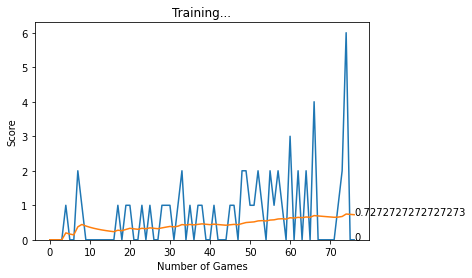

NameError: name 'quit' is not defined

In [21]:
from agent import Agent
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameAI()
    while True:
        state_old = agent.get_state(game)
        final_move = agent.get_action(state_old)
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)
        agent.train_short_memory(state_old, final_move, reward, state_new, done)
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()
            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)

if __name__ == '__main__':
    train()